コードと資料の対応

8ページ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imresize
from scipy import interpolate
import pickle
import pandas as pd
import time
import os

import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer import serializers




/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_dir = 'data'
model_dir = 'model'
fig_dir = 'fig'
temp_dir = 'temp'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [3]:
class Alex(chainer.Chain):
    insize = 227
    def __init__(self,dropout_rate = 0.0) :
        super(Alex, self).__init__(
            conv1=L.Convolution2D(None,  96, 11, stride=4),
            conv2=L.Convolution2D(None, 256,  5, pad=2),
            conv3=L.Convolution2D(None, 384,  3, pad=1),
            conv4=L.Convolution2D(None, 384,  3, pad=1),
            conv5=L.Convolution2D(None, 256,  3, pad=1),
            fc6=L.Linear(None, 4096),
            fc7=L.Linear(None, 4096),
            fc8=L.Linear(None, 1000),
        )
        self.dropout_rate = dropout_rate
    
    
    def __call__(self, x, layers):
        ret = {}
        en = layers[-1]
        h = self.conv1(x)
        if 'conv1' in layers:
            ret.update({'conv1':h})
            if en == 'conv1':
                return ret
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2) 
        h = F.dropout(self.conv2(h),ratio = self.dropout_rate)
        if 'conv2' in layers:
            ret.update({'conv2':h})
            if en == 'conv2':
                return ret
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2)
        h = F.dropout(self.conv3(h),ratio = self.dropout_rate)
        if 'conv3' in layers:
            ret.update({'conv3':h})
            if en == 'conv3':
                return ret
        h = F.relu(h)
        h = F.dropout(self.conv4(h),ratio = self.dropout_rate)
        if 'conv4' in layers:
            ret.update({'conv4':h})
            if en == 'conv4':
                return ret
        h = F.relu(h)
        h = F.dropout(self.conv5(h),ratio = self.dropout_rate)
        if 'conv5' in layers:
            ret.update({'conv5':h})
            if en == 'conv5':
                return ret
        h = F.max_pooling_2d(F.relu(h), 3, stride=2)
        h = F.dropout(self.fc6(h),ratio = self.dropout_rate)
        if 'fc6' in layers:
            ret.update({'fc6':h})
            if en == 'fc6':
                return ret
        h = F.relu(h)
        h = F.dropout(self.fc7(h),ratio = self.dropout_rate)
        if 'fc7' in layers:
            ret.update({'fc7':h})
            if en == 'fc7':
                return ret
        h = F.relu(h)
        h = self.fc8(h)
        if 'fc8' in layers:
            ret.update({'fc8':h})
        
        return ret
    
    def predict(self,x):
        h = self.__call__(x,layers ='fc8')['fc8']
        h = F.softmax(h)
        return h.data
    
    def get_layer_names(self):
        return ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
    
    def get_whole_units(self,layers):
        ret = {}
        if 'conv1' in layers:
            ret.update({'conv1':[96,55,55]})
        if 'conv2' in layers:
            ret.update({'conv2':[256,27,27]})
        if 'conv3' in layers:
            ret.update({'conv3':[384,13,13]})
        if 'conv4' in layers:
            ret.update({'conv4':[384,13,13]})
        if 'conv5' in layers:
            ret.update({'conv5':[256,13,13]})
        if 'fc6' in layers:
            ret.update({'fc6':[4096]})
        if 'fc7' in layers:
            ret.update({'fc7':[4096]})
        if 'fc8' in layers:
            ret.update({'fc8':[1000]})
        return ret



In [4]:
model = Alex()
serializers.load_npz(os.path.join(model_dir,'Alex.npz'),model)

8ページここまで

9ページ

In [6]:
def prepare(img):
    #convert PIL Image to numpy array for chainer
    
    #to numpy array
    img = np.asarray(img)
    if not img.shape == (1,3,227,227):
        #resize image to the size used in Alexnet
        img = imresize(img,np.array([227,227]))
        #to BGR, which is used color order in Alexnet
        img = img[:,:,[2,1,0]]
        #reorder img to order used in chainer and convert dtype to np.float32 for chainer
        img = img.transpose(2,0,1).astype(np.float32)
        #add batch dimension for chainer
        img = np.expand_dims(img,axis=0)
    
    return img

def check_label(prediction):
    #ラベルを読み込む
    categories = np.loadtxt('labels.txt')

    # スコアとラベルを紐づけスコアの高い順にソートする
    result = zip(prediction.data.reshape((prediction.data.size,)), categories)
    result = sorted(result, reverse=True)

    # 上位10個の結果を表示する
    for i, (score, label) in enumerate(result[:10]):
        print('{:>3d} {:>6.2f}% {}'.format(i + 1, score * 100, label))

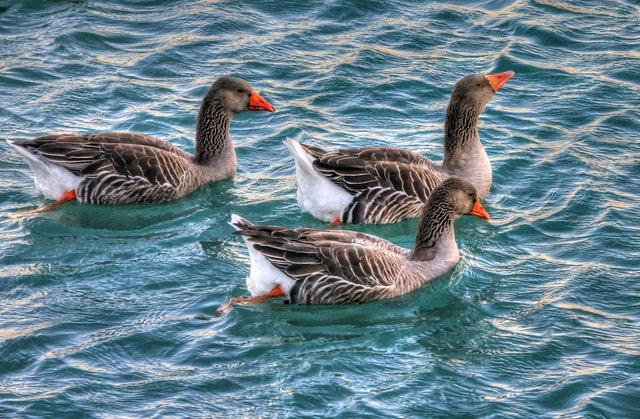

In [7]:
image = Image.open(os.path.join(data_dir,'geese.png'))
image

In [11]:
def preinput(img):
    """ 
    input image ... np.ndarray  227 * 227 * 3 [RGB] 
    
    return img 1 * 3 * 227 * 227 [BGR] sutable for Alex net
    """
    
    img = img.astype(np.float32)
    
    img = img[:,:,[2,1,0]]
    
    
    img = img.transpose(2,0,1).astype(np.float32)

    img = np.expand_dims(img,axis=0)
    
    return img


def show10results(prediction):
    #load label from outsize 
    categories = np.loadtxt(os.path.join(data_dir,'labels.txt'), str, delimiter="\n")

    # sort to higher score represented label
    result = zip(prediction.reshape((prediction.size,)), categories)
    result = sorted(result, reverse=True)

    # show top 10 results 
    print('top  percentage category')
    for i, (score, label) in enumerate(result[:10]):
        print('{:>3d} {:>6.2f}% {}'.format(i + 1, score * 100, label))

In [12]:
image = image.resize([227,227])
imgs = np.asarray(image)
img = preinput(imgs)
prediction = model.predict(img)

In [13]:
show10results(prediction)

top  percentage category
  1   3.16% black swan, Cygnus atratus
  2   2.77% red-breasted merganser, Mergus serrator
  3   2.08% snorkel
  4   1.40% goose
  5   1.32% stingray
  6   1.17% redshank, Tringa totanus
  7   1.13% breakwater, groin, groyne, mole, bulwark, seawall, jetty
  8   0.97% oystercatcher, oyster catcher
  9   0.95% albatross, mollymawk
 10   0.93% sea lion


9ページここまで


10ページ

In [14]:
prediction

array([[5.22364280e-04, 1.99426734e-03, 8.06120224e-03, 2.96727219e-03,
        5.21112699e-03, 1.73823035e-03, 1.31861940e-02, 2.50537437e-03,
        4.21261042e-03, 1.32012577e-03, 3.43617168e-04, 3.52748088e-04,
        1.34674681e-03, 7.58026086e-04, 2.06992016e-04, 6.52321265e-04,
        7.65189412e-04, 2.25414871e-04, 5.05925040e-04, 2.87220930e-04,
        1.25321944e-03, 3.11576499e-04, 1.09482068e-03, 1.53886876e-03,
        4.69147868e-04, 1.64648867e-04, 2.22683564e-04, 3.43542459e-04,
        1.29204243e-04, 5.89860836e-04, 9.89579828e-04, 2.59858149e-04,
        5.00906142e-04, 5.98729169e-03, 6.39285566e-03, 1.37989782e-03,
        2.51964713e-03, 6.74841460e-04, 4.80529969e-04, 3.85073526e-03,
        2.52218044e-04, 3.75726377e-04, 5.33511455e-04, 9.32348426e-04,
        8.62926943e-04, 5.88701863e-04, 2.76901934e-04, 2.97433580e-04,
        7.20379176e-04, 5.39220730e-03, 4.55101812e-03, 3.95172945e-04,
        5.95320773e-04, 1.41484675e-03, 1.43748452e-03, 3.038123

そのままプロット ( 間違い)

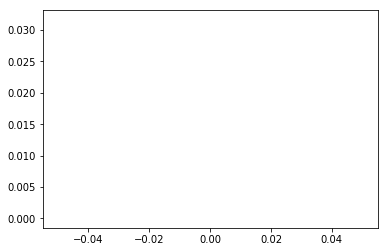

In [15]:
plt.plot(prediction)

縦ベクトルを横にしてプロット


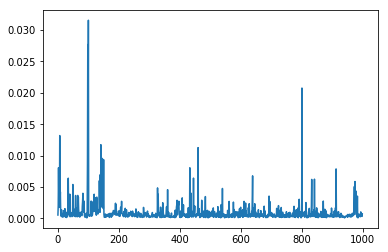

In [16]:
plt.plot(prediction.T)

10ページここまで 

11ページ

中間層の名前

In [17]:
model.get_layer_names()

['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']

fc6層の確認

In [18]:
mid = model(img,'fc6')['fc6']

In [19]:
mid

variable([[-9.373365 , -6.108699 ,  2.1165552, ..., -7.9908934,
            1.5388994, -2.588047 ]])

variable型をnumpy.arrayに変換してプロット

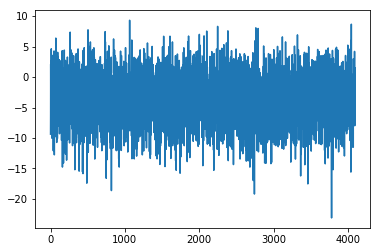

In [20]:
plt.plot(mid.data.T)

11ページここまで

12ページ

In [21]:
mid = model(img,'conv3')['conv3']
mid

variable([[[[  7.5664043 ,   7.6154623 ,   8.996258  , ...,
              12.91667   ,  10.614345  ,   7.8313684 ],
            [  0.5001572 ,  -4.1089153 ,   0.10375212, ...,
              -2.3801389 ,   0.640027  ,  -0.09118165],
            [  6.000008  ,  -0.937331  ,   0.33570746, ...,
              -4.2516794 ,  -4.2715716 ,  -0.51176614],
            ...,
            [  6.351583  ,  -4.4752173 ,  -6.1098976 , ...,
             -12.278226  ,  -5.610182  ,  -3.4709556 ],
            [  8.013883  ,  -2.4831767 ,  -2.1600094 , ...,
              -8.552955  ,  -4.216358  ,  -3.2121046 ],
            [  2.6373446 ,   2.7966115 ,   5.9745355 , ...,
              -4.031385  ,   1.5328763 ,   2.22549   ]],

           [[  2.8113856 ,   6.779373  ,   7.2337604 , ...,
              -7.9057283 ,  -3.4445596 ,  11.83862   ],
            [ 13.627173  ,  17.023014  ,  13.342601  , ...,
               7.261552  ,  12.532216  ,  26.226295  ],
            [ 16.162655  ,  15.837957  ,  11.354088  

In [22]:
midarr = mid.data

In [23]:
midarr.shape

(1, 384, 13, 13)

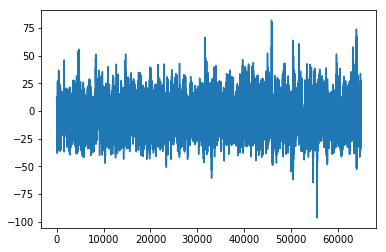

In [24]:
plt.plot(midarr.ravel())

12ページここまで

20ページ

In [28]:
import numpy as np
from numpy import matlib


def make_orientation_image(theta,t = 0,omega = 0.08,size = 227):
    # make orientation image
    x = np.arange(-size/2.0,size/2.0)
    y = np.arange(-size/2.0,size/2.0)

    xx = matlib.repmat(x,len(x),1)
    yy = matlib.repmat(y,len(y),1).T
    
    xy_rotation = xx*np.cos(theta)-yy*np.sin(theta)
    wave = np.cos(xy_rotation*omega+t)
    temp = wave - np.min(wave)
    wave = temp / np.max(temp)*255
    wave = np.stack([wave]*3,axis=2).astype(np.uint8)
    return(wave)

In [29]:
rad = np.pi *3/4
t =0
s = make_orientation_image(rad,t)

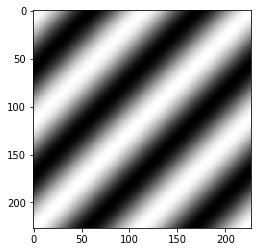

In [30]:
plt.imshow(s)

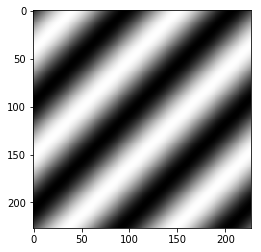

In [31]:
s = make_orientation_image(rad,2)
plt.imshow(s)

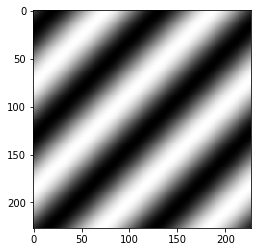

In [32]:
s = make_orientation_image(rad,4)
plt.imshow(s)

20ページここまで

22ページ

In [33]:
# 1. 方位を定義
rad = np.pi/4
# 2. 活動を記録するユニットのindex を決める
index = 53172
# 3. ある時刻における活動値を記録する空のリストを作る
m_list = []
for i in range(50):
    # 時刻における画像を生成する
    img = make_orientation_image(rad,i)
    # alex net に入力する
    img = preinput(img)
    act = model(img,'conv1')['conv1']
    act_relu = F.relu(act).data
    # 活動値をリストに記録する
    act_vec = act_relu.ravel()
    m_list.append(act_vec[index])
# 平均をとる    
np.mean(m_list)

1.01287

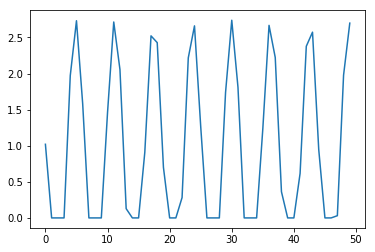

In [34]:
# 時間ごとのプロット
plt.plot(m_list)

22ページここまで

23ページ

In [35]:
m_list = []
num = 53172
for r in range(17):
    rad = np.pi / 16 * r
    rad_list = []
    
    for s in range(50):
        imgs = make_orientation_image(rad,s)
        img = preinput(imgs)
        fea = F.relu(model(img,layers =['conv1'])['conv1']).data
        rad_list.append(fea.ravel()[num])
   
   
    #arry = np.asarray(rad_list)
    arry = rad_list   
    m_list.append(np.mean(arry,0))
    
m_arry = np.asarray(m_list)

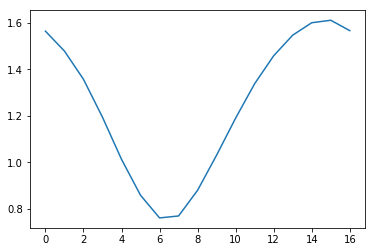

In [36]:
plt.plot(m_list)

別解(conv1の全ての活動値をとっておく方法)

In [37]:
m_list = []

for r in range(17):
    rad = np.pi / 16 * r
    rad_list = []
    
    for s in range(50):
        imgs = make_orientation_image(rad,s)
        img = preinput(imgs)
        fea = F.relu(model(img,layers =['conv1'])['conv1']).data
        rad_list.append(fea.ravel())
   
   
    arry = np.asarray(rad_list)
        
    m_list.append(np.mean(arry,0))
    
m_arry = np.asarray(m_list)

In [38]:
rad = [ np.pi/16 * i *180/np.pi for i in range(17)]

In [39]:
rad

[0.0,
 11.25,
 22.5,
 33.75,
 45.0,
 56.25,
 67.5,
 78.75,
 90.0,
 101.24999999999999,
 112.5,
 123.74999999999999,
 135.0,
 146.25000000000003,
 157.5,
 168.74999999999997,
 180.0]

Text(0.5,0,'Angle')

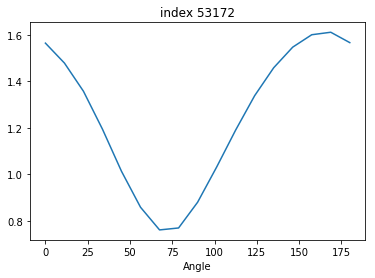

In [40]:
#index = 277913
plt.plot(rad,m_arry[:,index])
plt.title('index ' +str(index) )
plt.xlabel('Angle')
#plt.savefig(str(index) +'tuning curve.jpg')

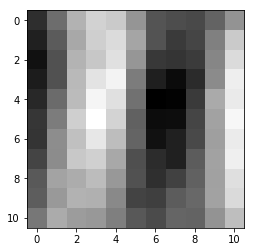

In [43]:
fea = model.conv1.W.data[int(index/(55 * 55))].transpose(1,2,0)
rf = (fea - np.min(fea))/np.max(fea -np.min(fea)) * 2 -1
plt.imshow(rf[:,:,0])

plt.gray()

In [44]:
m_arry[:,index]

array([0.        , 0.        , 0.00265834, 0.05442299, 0.13516551,
       0.15820225, 0.12771298, 0.0605411 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ], dtype=float32)

In [45]:
55 * 55 * 3

9075

Text(0.5,1,'index 10125')

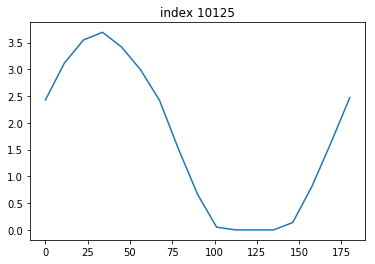

In [46]:
index =10125

plt.plot(rad,m_arry[:,index])
plt.title('index ' +str(index) )
#plt.savefig(str(index) +'tuning curve.jpg')

Text(0.5,1,'10125')

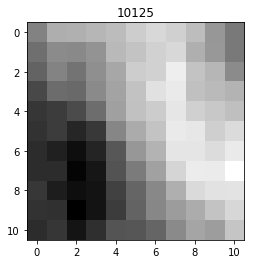

In [48]:
fea = model.conv1.W.data[int(index/(55 * 55))].transpose(1,2,0)
rf = (fea - np.min(fea))/np.max(fea -np.min(fea)) * 2 -1
plt.imshow(rf[:,:,0])
plt.gray()
plt.title( index)

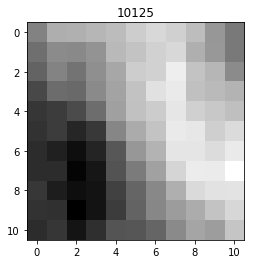

In [49]:

fea = model.conv1.W.data[int(index/(55 * 55))].transpose(1,2,0)
rf = (fea - np.min(fea))/np.max(fea -np.min(fea)) * 2 -1
plt.imshow(rf[:,:,0])
plt.gray()
plt.title( index)
#plt.savefig(str(index) +'true_weight.jpg')

Text(0.5,1,'index 200')

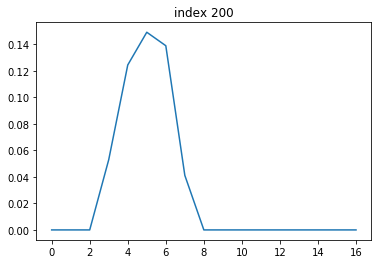

In [50]:
index = 200
plt.plot(m_arry[:,index])
plt.title('index ' +str(index) )
#plt.savefig(str(index) +'tuning curve.jpg')

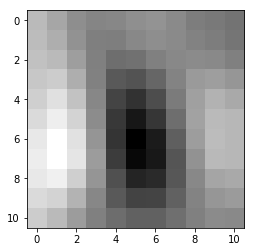

In [53]:
fea = model.conv1.W.data[int(index/(55 * 55))].transpose(1,2,0)
rf = (fea - np.min(fea))/np.max(fea -np.min(fea)) * 2 -1
plt.imshow(rf[:,:,0])
plt.gray()

Text(0.5,1,'index 53997')

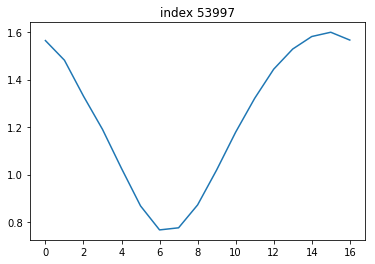

In [54]:
index = 53997
plt.plot(m_arry[:,index])
plt.title('index ' +str(index) )
#plt.savefig(str(index) +'tuning curve.jpg')

Text(0.5,1,'index 133452')

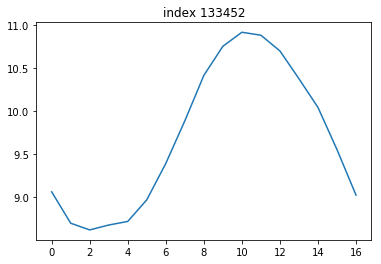

In [55]:
index = 133452
plt.plot(m_arry[:,index])
plt.title('index ' +str(index) )

Text(0.5,1,'index 10')

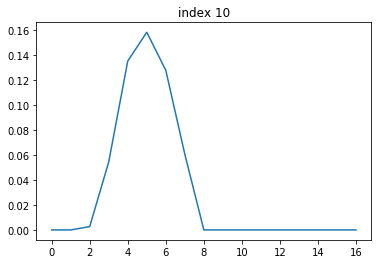

In [56]:
index = 10
plt.plot(m_arry[:,index])
plt.title('index ' +str(index) )

Text(0.5,1,'index 607')

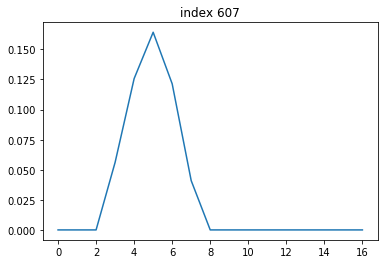

In [57]:
index = 607
plt.plot(m_arry[:,index])
plt.title('index ' +str(index) )

Text(0.5,1,'index 6048')

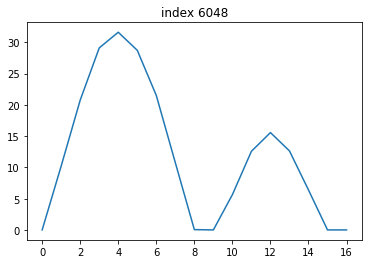

In [58]:
index = 6048
plt.plot(m_arry[:,index])
plt.title('index ' +str(index) )

重みの取り出し

In [59]:
model.conv1.W.data.shape

(96, 3, 11, 11)

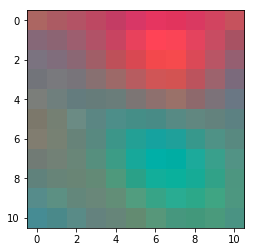

In [60]:
fea = model.conv1.W.data[12].transpose(1,2,0)

plt.imshow((fea - np.min(fea))/np.max(fea -np.min(fea)))
plt.gray()

In [61]:
(fea - np.min(fea)/np.max(fea -np.min(fea)))

array([[[0.5362219 , 0.44973946, 0.44500712],
        [0.53581035, 0.43674108, 0.44660342],
        [0.54489714, 0.42711046, 0.44907856],
        [0.55701536, 0.4137442 , 0.4450827 ],
        [0.5652196 , 0.39917552, 0.44720504],
        [0.58954036, 0.39289936, 0.45044675],
        [0.6061277 , 0.39017236, 0.44343084],
        [0.60168743, 0.38898796, 0.4386881 ],
        [0.5915471 , 0.39504808, 0.44373745],
        [0.58256686, 0.4086612 , 0.44319236],
        [0.56803787, 0.42538148, 0.439593  ]],

       [[0.4890366 , 0.45300698, 0.47180408],
        [0.49605393, 0.44731405, 0.46647668],
        [0.51719046, 0.44059283, 0.4616143 ],
        [0.54138106, 0.4255916 , 0.45121837],
        [0.5703834 , 0.4088721 , 0.44444534],
        [0.60891473, 0.4046147 , 0.4385459 ],
        [0.6365621 , 0.40706873, 0.43047437],
        [0.63085485, 0.40850738, 0.4309076 ],
        [0.60437614, 0.4070928 , 0.4403114 ],
        [0.56976026, 0.41838562, 0.44505346],
        [0.53053766, 0.42528918,

In [62]:
model.conv1.W.data.shape

(96, 3, 11, 11)